In [ ]:
import random
from pipe import *

Theo used a simple samping approach to compute the probability using a simulated "Monte Carlo" approach.

In [813]:
def yearly_simulation( test_days=52 ):

    # the drunk days is locked to once per month
    drunk = set( random.sample( range(260), 12 ) ) 
    test =  set( random.sample( range(260), test_days ) )

    return len(drunk.intersection(test)) > 0

def run_monte_carlo(test_days=52, iterations=10000):
    
    answers = range(iterations) \
        | select( lambda x: yearly_simulation(test_days) ) \
        | as_list

    trues = answers | where( lambda x: x == True ) | count
    falses = answers | where( lambda x: x==False ) | count

    return (trues / (trues+falses))
    
print( f"EveryDay: {run_test(260)}" )
print( f"Weekly: {run_test(52)}" )
print( f"Monthly: {run_test(12)}" )
print( f"Twice: {run_test(2)}" )
print( f"Annual: {run_test(1)}" )

EveryDay: 1.0
Weekly: 0.931
Monthly: 0.432
Twice: 0.076
Annual: 0.049


Initially, I didn't trust this because the code seems flawed. 

For example it's possible in this simulation to have 12 drunk days in a single month. It seemed to make more sense to canonically distribute the drunk and test days canonically across time. 

As it transpired later, it didn't seem to make much difference (especially with higher test frequency). I think this is because;

* We are running the simulation a lot of times
* In some sense, it doesn't matter "when" it happened, just the frequency matters
* There won't be day collisions due to use of sample function

But for completness, I tried stratifying the time with the following functions;

In [824]:
# printing this out so you can see how I am encoding days in the following functions
# i.e. (month, week, day)
# this approach is not perfect i.e. it will come out at 48 weeks in a year not 52
# but at least it will stratify the events more realistically

print( range(10) \
        | select(lambda d: (random.randint(0,11), 
                            random.randint(0,3), 
                            random.randint(0,4) ) ) \
        | select( lambda t: ( str(t), 1 ) ) \
        | as_dict )


{'(2, 2, 1)': 1, '(6, 2, 3)': 1, '(11, 3, 4)': 1, '(1, 2, 1)': 1, '(6, 2, 1)': 1, '(11, 3, 3)': 1, '(11, 0, 0)': 1, '(9, 3, 0)': 1, '(9, 0, 4)': 1, '(0, 1, 2)': 1}


In [820]:
def annualtest_yearsimulation():
    # days keyed on tuple string (month, week, day)

    # two testing days per year
    # note that these two days could be the same ~1/260^2 but negligable
    days_test = range(1) \
        | select(lambda d: (random.randint(0,11), 
                            random.randint(0,3), 
                            random.randint(0,4) ) ) \
        | select( lambda t: ( str(t), 1 ) ) \
        | as_dict
        
    # monthly testing days (should be 12)
    days_monthlydrunk = range(12) \
        | select(lambda month: (month, random.randint(0,3), random.randint(0,4) ) ) \
        | as_list

    caught_times = days_monthlydrunk \
        | where( lambda dd: days_test.get( str( dd ) ) == 1 ) \
        | count 
    
    return caught_times

answers = range(100000) \
    | select( lambda x: twiceyearlytest_yearsimulation() ) \
    | as_list

trues = answers | where( lambda x: x>0 ) | count
falses = answers | where( lambda x: x==0 ) | count

print( "Annual simulation was %f, monte carlo said 0.049" % (trues / (trues+falses)) )

Annual simulation was 0.096530, monte carlo said 0.049


In [816]:
def twiceyearlytest_yearsimulation():
    # days keyed on tuple string (month, week, day)

    # two testing days per year
    # note that these two days could be the same ~1/260^2 but negligable
    days_test = range(2) \
        | select(lambda d: (random.randint(0,11), 
                            random.randint(0,3), 
                            random.randint(0,4) ) ) \
        | select( lambda t: ( str(t), 1 ) ) \
        | as_dict
        
    # monthly testing days (should be 12)
    days_monthlydrunk = range(12) \
        | select(lambda month: (month, random.randint(0,3), random.randint(0,4) ) ) \
        | as_list

    caught_times = days_monthlydrunk \
        | where( lambda dd: days_test.get( str( dd ) ) == 1 ) \
        | count 
    
    return caught_times

answers = range(100000) \
    | select( lambda x: twiceyearlytest_yearsimulation() ) \
    | as_list

trues = answers | where( lambda x: x>0 ) | count
falses = answers | where( lambda x: x==0 ) | count

print( "Twice anual simulation was %f, monte carlo said 0.076" % (trues / (trues+falses)) )

Twice anual simulation was 0.097660, monte carlo said 0.076


In [817]:
def monthlytest_yearsimulation():
    # days keyed on tuple string (month, week, day)

    # weekly testing days (should be 48 which is nearly 52, good enough)
    days_monthlytest = range(12) \
        | select(lambda month: (month, random.randint(0,3), random.randint(0,4) ) ) \
        | select( lambda t: ( str(t), 1 ) ) \
        | as_dict

    # monthly testing days (should be 12)
    days_monthlydrunk = range(12) \
        | select(lambda month: (month, random.randint(0,3), random.randint(0,4) ) ) \
        | as_list

    caught_times = days_monthlydrunk \
        | where( lambda dd: days_monthlytest.get( str( dd ) ) == 1 ) \
        | count 
    
    return caught_times

answers = range(10000) \
    | select( lambda x: monthlytest_yearsimulation() ) \
    | as_list

trues = answers | where( lambda x: x>0 ) | count
falses = answers | where( lambda x: x==0 ) | count

print( "Monthly simulation was %f, monte carlo said 0.432" % (trues / (trues+falses)) )

Monthly simulation was 0.454200, monte carlo said 0.432


In [818]:
def weeklytest_yearsimulation():
    # days keyed on tuple string (month, week, day)

    # weekly testing days (should be 48 which is nearly 52, good enough)
    days_weeklytest = range(12) \
        | select(lambda month: range(4)  \
                 | select( lambda week: (month, week, random.randint(0,4) )  ) \
                      | as_list ) \
                        | chain \
                        | select( lambda t: ( str(t), 1 ) ) \
                        | as_dict

    # monthly testing days (should be 12)
    days_monthlydrunk = range(12) \
        | select(lambda month: (month, random.randint(0,3), random.randint(0,4) ) ) \
        | as_list

    caught_times = days_monthlydrunk \
        | where( lambda dd: days_weeklytest.get( str( dd ) ) == 1 ) \
        | count 
    
    return caught_times

answers = range(100000) \
    | select( lambda x: weeklytest_yearsimulation() ) \
    | as_list

trues = answers | where( lambda x: x>0 ) | count
falses = answers | where( lambda x: x==0 ) | count

print( "Weekly simulation was %f, monte carlo said 0.931" % (trues / (trues+falses)) )

Weekly simulation was 0.932070, monte carlo said 0.931


OK so the naive monte carlo simulation is actually pretty good. The monte carlo seems to get more accurate as the number of tests increases which is intuative

Let's run a bunch of tests for different days and capture the results

In [751]:
growth = range( 200 ) \
    | select( lambda d: (d, run_test(d) ) ) \
    | as_list

In [758]:
import numpy as np

ga = np.array(growth)

Plotting the growth

Text(0,0.5,'Probability of getting caught')

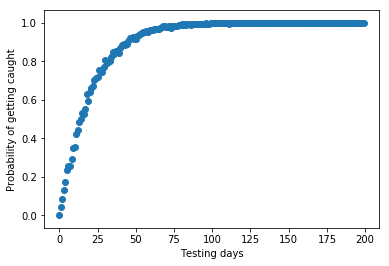

In [764]:
import matplotlib.pyplot as plt

plt.scatter( ga[:,0], ga[:,1] )
plt.xlabel("Testing days")
plt.ylabel("Probability of getting caught")

This should be instantly recognisable as an exponential curve ;) 

Let's play with some exponential functions and figure out how to model the curve, reminicent of compound interest calculations in computational finance, should be pretty easy to scale the exponential as a function of the drinking liklihood

Text(0,0.5,'Probability of getting caught')

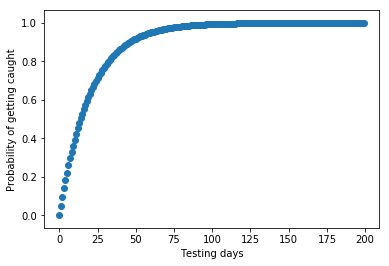

In [792]:
import math 

values = range(200) | select( lambda d: 1-math.exp(-d*(1/20)) ) | as_list

ga2 = np.zeros( (200,2) )

ga2[:,0] = np.array(range(200))
ga2[:,1] = np.array(v)

plt.scatter( ga2[:,0], ga2[:,1] )
plt.xlabel("Testing days")
plt.ylabel("Probability of getting caught")

This looks like a pretty much spot-on match! Let's plot them on top of each other to verify

Text(0,0.5,'Probability of getting caught')

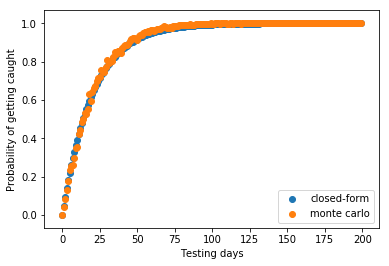

In [928]:
plt.scatter( ga2[:,0], ga2[:,1] )
plt.scatter( ga[:,0], ga[:,1])
plt.legend(["closed-form", "monte carlo"])
plt.xlabel("Testing days")
plt.ylabel("Probability of getting caught")

Now let's create our final closed form function to compute the annual probability of getting caught with different numbers of testing days

In [850]:
# note the 1/20 number wasn't plucked out of thin air, it means 
# "one day in every month, where there are 20 working days in a month"

def caught_prob_closed_form(test_days = 52):
    return 1-math.exp(-test_days*(1/20))

[1,2,12,52,260] \
    | select( lambda d: (d, caught_prob_closed_form(d))) | as_list

[(1, 0.048770575499285984),
 (2, 0.09516258196404048),
 (12, 0.4511883639059736),
 (52, 0.9257264217856661),
 (260, 0.999997739670593)]

The exponential function is capturing some kind of "compounding" of the probability

This is because in probability theory, two independent events $A$ and $B$ both occuring i.e. $P(A,B)$ is $P(B|A) \times P(B)$ and we can think of this problem in reverse of "how likely is it I can evade $E$ capture N times" as a joint probability of $N$ evades i.e. $$1 - ( P(E_1) \times P(E_2) \times \cdots \times P(E_N) )$$ 

We add $1-$ to get back to the probability of getting caught that year

First of all, roughly what's happening is this for 12 tests;

In [918]:
drunk_days = 12
test_days = 12

1-math.pow( (days - drunk_days)/days, test_days)

0.44852749345588583

Which is pretty much the same as our $1-$ monthly drunk fraction i.e. "how often are we sober" (about 95% of the time);

In [916]:
1-math.pow( 1-(1/20), 12)

0.45963991233736334

Seems pretty close to our closed form solution;

In [917]:
caught_prob_closed_form(12)

0.4511883639059736

So we are computing the days "evaded" and multiplying it 12 times for each test i.e. $$0.95 \times 0.95  \times 0.95  \times \cdots  \times 0.95$$

Of course it's not quite the same number every time but in practice it doesn't make much difference, because the number of tests and days decrease with each iteration;

`
evade/days: 247/259=0.9536679536679536
evade/days: 246/258=0.9534883720930233
evade/days: 245/257=0.953307392996109
evade/days: 244/256=0.953125
evade/days: 243/255=0.9529411764705882
`

In [919]:
def caught_prob_algorithm(test_days=52):
    days = 260
    drunk_days = 12
    evade = days - drunk_days
    prob = evade/days
    
    for d in range(test_days):
        days = days - 1
        evade = evade - 1
        prob = prob * evade / days
        
    prob = 1 - prob
    
    return prob

[1,2,12,52, 100] \
    | select( lambda d: (d, caught_prob_algorithm(d))) | as_list

[(1, 0.09034749034749023),
 (2, 0.1326569094010953),
 (12, 0.46703442406734663),
 (52, 0.9393596532451094),
 (100, 0.9976868268264146)]

Text(0,0.5,'Probability of getting caught')

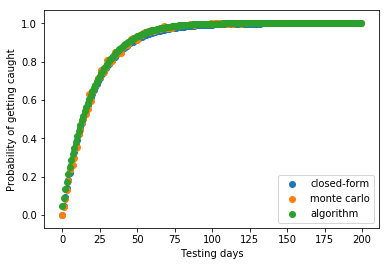

In [929]:
alg_values = range(200) | select( lambda d: caught_prob_algorithm(d) ) | as_list

plt.scatter( ga2[:,0], ga2[:,1] )
plt.scatter( ga[:,0], ga[:,1])
plt.scatter( ga[:,0], np.array(alg_values))

plt.legend(["closed-form", "monte carlo", "algorithm"])
plt.xlabel("Testing days")
plt.ylabel("Probability of getting caught")

So having the model the probability of evasion is what makes this problem unintuative, similar to the solution to the monte hall problem where you have to think of the probability of selecting a goat instead of the gold.

If there is only 1 test we should be able to calculate that directly and have the value match up i.e. 12/260

In [971]:
(12 / 260)

# monte carlo said 0.049
# closed form (exponential) said 0.048
# algorithm said 0.09 (??) 

0.046153846153846156

This is making me question the accuracy of the algorithm, maybe we don't need to take the days away at all?

Let's plot the residuals of the monte carlo - probability algorithm

Text(0,0.5,'residual')

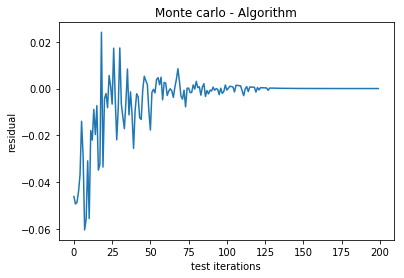

In [966]:
closed_form = ga2[:,1]
monte_carlo = ga[:,1]
algorithm = alg_values

plt.plot( monte_carlo - algorithm )
plt.title("Monte carlo - Algorithm")
plt.xlabel("test iterations")
plt.ylabel("residual")

Seems to stabalise with more tests, let's compare the algorithm and the closed form solution

Text(0,0.5,'residual')

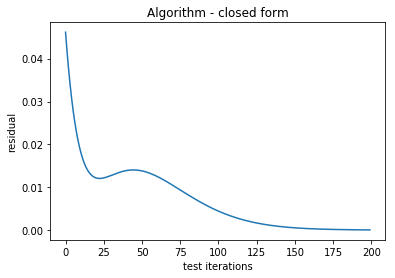

In [981]:
plt.plot( algorithm - closed_form )
plt.title("Algorithm - closed form")
plt.xlabel("test iterations")
plt.ylabel("residual")

So the algorithm starts to incur more and more error as the test iterations goes down

Text(0,0.5,'residual')

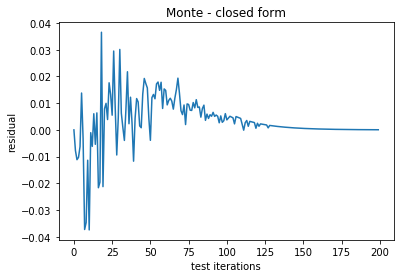

In [980]:
plt.plot( monte_carlo - closed_form )
plt.title("Monte - closed form")
plt.xlabel("test iterations")
plt.ylabel("residual")

This in combination with the fact that $(12 / 260)$ agrees with monte carlo and closed form seems to be pretty good evidence that the algorithm from Theo chipping off days is wrong, it's noisy due to the stochastic nature of the simulation but it's still somewhat balanced around 0. It's possible that Theo's algorithm is right but reporting the wrong result due to numerical precision issues. 

Another version of the algorithm which doesn't chip off days, we re-write it several ways to combat numerical precision issues

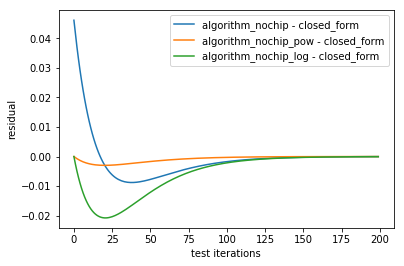

In [1098]:
# this way is written similar to the original
def caught_prob_algorithm_nochip(test_days=52):
    days = 260
    drunk_days = 12
    evade = days - drunk_days
    prob = evade/days
    
    for d in range(test_days):
        prob = prob * (evade / days)
        
    prob = 1 - prob
    
    return prob

def caught_prob_algorithm_nochip_pow(test_days=52):
    drunk_days = 12
    evade = days - drunk_days
    prob = evade/ 260
    
    return 1 - math.pow( evade/days, test_days )

# we can do a neat trick in maths with probabilities, turn them into log-probabilities then
# add them up, then you don't run out of precision i.e. with 0.000x * 0.000x
def caught_prob_algorithm_nochip_log(test_days=52):
    drunk_days = 12
    evade = 260 - drunk_days
    prob = evade / 260
    
    return 1-(math.exp( math.log(prob)*test_days ))

algorithm_nochip = range(200) | select( lambda d: caught_prob_algorithm_nochip(d) ) | as_list
algorithm_nochip_pow = range(200) | select( lambda d: caught_prob_algorithm_nochip_pow(d) ) | as_list
algorithm_nochip_log = range(200) | select( lambda d: caught_prob_algorithm_nochip_log(d) ) | as_list

plt.plot( algorithm_nochip - closed_form )
plt.plot( algorithm_nochip_pow - closed_form )
plt.plot( algorithm_nochip_log - closed_form )
plt.xlabel("test iterations")
plt.ylabel("residual")
plt.legend(["algorithm_nochip - closed_form", 
            "algorithm_nochip_pow - closed_form", 
           "algorithm_nochip_log - closed_form"])

Looks like a lot of the discrepancy is caused by numerical precision issues! But which one do we trust the most? The log version should have the lowest error, but it looks weird

Text(0,0.5,'residual')

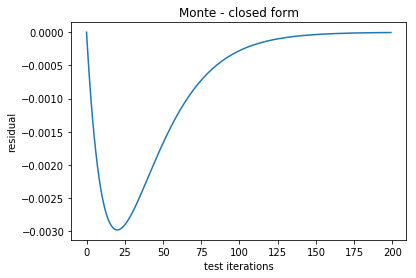

In [1106]:
plt.plot(  algorithm_nochip_pow - closed_form)
plt.title("Monte - closed form")
plt.xlabel("test iterations")
plt.ylabel("residual")

Still seeing a weird error artefact on low iterations (pretty negligable though i.e. -> 0.0030), I assume still caused by numerical error -- but this is getting somewhat academic now -- I think the take home message is that the simple exponential function is the way to go